In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, zipfile, random, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from collections import Counter

In [3]:
# SMART EXTRACTION + FOLDER DETECTION FIX

import zipfile, shutil, os
from pathlib import Path

# Define paths
DATA_ROOT = Path("./data_extracted_fixed")
TRAIN_ZIP = "/content/train-20251030T072323Z-1-001.zip"
VALID_ZIP = "/content/valid-20251030T072326Z-1-001.zip"
TEST_ZIP  = "/content/test-20251030T072323Z-1-001.zip"

# Clean old extraction if exists
if DATA_ROOT.exists():
    shutil.rmtree(DATA_ROOT)
DATA_ROOT.mkdir(parents=True, exist_ok=True)

def smart_extract(zip_path, target_dir):
    """Extract zip and automatically detect the actual 'train/valid/test' folder level."""
    print(f"Extracting {zip_path} ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_dir)
    print(f"Extracted to {target_dir}")

    # Find the real dataset folder (contains class subfolders)
    # e.g., /data/train/train/...  or /data/train/...
    candidates = list(Path(target_dir).rglob("train"))
    if not candidates:
        candidates = list(Path(target_dir).rglob("Train"))
    if candidates:
        print(f"Found train folder candidate: {candidates[0]}")
    return target_dir

# Extract all datasets
smart_extract(TRAIN_ZIP, DATA_ROOT / "train")
smart_extract(VALID_ZIP, DATA_ROOT / "valid")
smart_extract(TEST_ZIP,  DATA_ROOT / "test")

# Detect the deepest actual directories that contain class folders
def find_actual_dataset_dir(base_dir):
    base_dir = Path(base_dir)
    subdirs = [p for p in base_dir.rglob("*") if p.is_dir() and any(f.suffix.lower() in ['.jpg', '.jpeg', '.png'] for f in p.glob("*"))]
    if subdirs:
        # Return parent folder containing class folders
        parents = {p.parent for p in subdirs}
        best = min(parents, key=lambda p: len(p.parts))
        print(f"✅ Found valid dataset directory: {best}")
        return best
    else:
        print(f"⚠️ No images found under {base_dir}, check your zip structure.")
        return base_dir

TRAIN_DIR = find_actual_dataset_dir(DATA_ROOT / "train")
VALID_DIR = find_actual_dataset_dir(DATA_ROOT / "valid")
TEST_DIR  = find_actual_dataset_dir(DATA_ROOT / "test")

print(f"\nFinal dataset directories:")
print(f"Train dir: {TRAIN_DIR}")
print(f"Valid dir: {VALID_DIR}")
print(f"Test dir:  {TEST_DIR}")

# Quick verification
for root, dirs, files in os.walk(TRAIN_DIR):
    print(f"\nSample structure check:\n{root} -> {len(dirs)} class folders")
    print("Classes:", dirs)
    break

Extracting /content/train-20251030T072323Z-1-001.zip ...
Extracted to data_extracted_fixed/train
Found train folder candidate: data_extracted_fixed/train/train
Extracting /content/valid-20251030T072326Z-1-001.zip ...
Extracted to data_extracted_fixed/valid
Extracting /content/test-20251030T072323Z-1-001.zip ...
Extracted to data_extracted_fixed/test
✅ Found valid dataset directory: data_extracted_fixed/train/train
✅ Found valid dataset directory: data_extracted_fixed/valid/valid
✅ Found valid dataset directory: data_extracted_fixed/test/test

Final dataset directories:
Train dir: data_extracted_fixed/train/train
Valid dir: data_extracted_fixed/valid/valid
Test dir:  data_extracted_fixed/test/test

Sample structure check:
data_extracted_fixed/train/train -> 4 class folders
Classes: ['meningioma', 'pituitary', 'glioma', 'no_tumor']


In [4]:
# 1) CONFIG

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_ROOT = Path("data_extracted_fixed")   # already extracted (from your previous step)
TRAIN_DIR = DATA_ROOT / "train" / "train"
VALID_DIR = DATA_ROOT / "valid" / "valid"
TEST_DIR  = DATA_ROOT / "test" / "test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
OUTPUT_DIR = Path("models_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

In [5]:
# 2️) DATA PREPROCESSING (Fixed for RGB inputs)

print("✅ Preparing datasets...")

def create_dataset(directory, img_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        batch_size=batch_size,
        image_size=img_size,
        shuffle=shuffle,
        seed=SEED,
        color_mode="rgb"   # 👈 Force 3-channel RGB to avoid grayscale mismatch
    )
    return ds

train_ds = create_dataset(TRAIN_DIR)
val_ds   = create_dataset(VALID_DIR, shuffle=False)
test_ds  = create_dataset(TEST_DIR, shuffle=False)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# ✅ Sanity check: verify image shape
for images, labels in train_ds.take(1):
    print(f"Sample image batch shape: {images.shape}")
    print(f"Sample label batch shape: {labels.shape}")

# Normalize pixel values to [0–1]
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

✅ Preparing datasets...
Found 1695 files belonging to 4 classes.
Found 502 files belonging to 4 classes.
Found 246 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Sample image batch shape: (32, 224, 224, 3)
Sample label batch shape: (32,)


In [6]:
# 3️) DATA AUGMENTATION

print("✅ Setting up augmentation...")
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

✅ Setting up augmentation...


In [7]:
# 4️) MODEL BUILDING (Fixed & Verified)

print("✅ Building models...")

# ---- Custom CNN ----
def build_custom_cnn(input_shape=(224,224,3), num_classes=4):
    model = models.Sequential([
        data_augmentation,
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

custom_cnn = build_custom_cnn((224,224,3), num_classes)
custom_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
custom_cnn.summary()

# ---- Transfer Learning Models ----
def build_transfer_model(base_model, num_classes=4):
    base_model.trainable = False
    inputs = layers.Input(shape=(224,224,3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

transfer_models = {
    "ResNet50": build_transfer_model(applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
    "MobileNetV2": build_transfer_model(applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
    "InceptionV3": build_transfer_model(applications.InceptionV3(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
}

✅ Building models...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


✅ Training models...

Training CustomCNN ...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4428 - loss: 1.5237

53/53 ━━━━━━━━━━━━━━━━━━━━ 460s 8s/step - accuracy: 0.4440 - loss: 1.5206 - val_accuracy: 0.3685 - val_loss: 1.3537
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5999 - loss: 1.1623

53/53 ━━━━━━━━━━━━━━━━━━━━ 438s 8s/step - accuracy: 0.5996 - loss: 1.1632 - val_accuracy: 0.3207 - val_loss: 1.3313
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 445s 8s/step - accuracy: 0.5978 - loss: 1.1123 - val_accuracy: 0.3207 - val_loss: 1.3472
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 445s 8s/step - accuracy: 0.6183 - loss: 1.0635 - val_accuracy: 0.3207 - val_loss: 1.5272
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 442s 8s/step - accuracy: 0.6205 - loss: 1.0710 - val_accuracy: 0.3546 - val_loss: 1.7545
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 425s 8s/step - accuracy: 0.6086 - loss: 1.1428 - val_accuracy: 0.3367 - val_loss: 1.8316


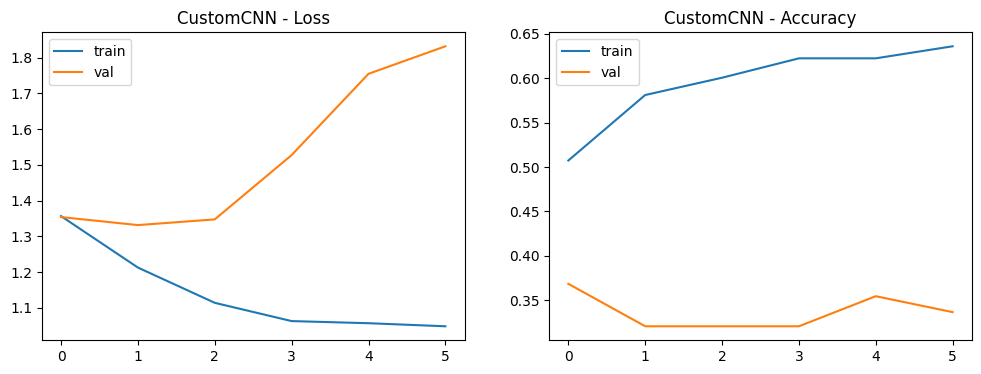


Training ResNet50 ...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2066 - loss: 2.1294

53/53 ━━━━━━━━━━━━━━━━━━━━ 495s 9s/step - accuracy: 0.2066 - loss: 2.1258 - val_accuracy: 0.2470 - val_loss: 1.5606
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2548 - loss: 1.5892

53/53 ━━━━━━━━━━━━━━━━━━━━ 490s 9s/step - accuracy: 0.2551 - loss: 1.5884 - val_accuracy: 0.2610 - val_loss: 1.3842
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2799 - loss: 1.4788

53/53 ━━━━━━━━━━━━━━━━━━━━ 464s 9s/step - accuracy: 0.2801 - loss: 1.4785 - val_accuracy: 0.2809 - val_loss: 1.3651
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2944 - loss: 1.4863

53/53 ━━━━━━━━━━━━━━━━━━━━ 503s 9s/step - accuracy: 0.2943 - loss: 1.4861 - val_accuracy: 0.3426 - val_loss: 1.3541
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3032 - loss: 1.4726

53/53 ━━━━━━━━━━━━━━━━━━━━ 513s 10s/step - accuracy: 0.3032 - loss: 1.4724 - val_accuracy: 0.3546 - val_loss: 1.3409
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3279 - loss: 1.4070

53/53 ━━━━━━━━━━━━━━━━━━━━ 476s 9s/step - accuracy: 0.3275 - loss: 1.4074 - val_accuracy: 0.4024 - val_loss: 1.3297
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3339 - loss: 1.4159

53/53 ━━━━━━━━━━━━━━━━━━━━ 480s 9s/step - accuracy: 0.3335 - loss: 1.4161 - val_accuracy: 0.4124 - val_loss: 1.3166
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2920 - loss: 1.4342

53/53 ━━━━━━━━━━━━━━━━━━━━ 536s 10s/step - accuracy: 0.2924 - loss: 1.4337 - val_accuracy: 0.4124 - val_loss: 1.3093
Epoch 9/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3115 - loss: 1.4037

53/53 ━━━━━━━━━━━━━━━━━━━━ 473s 9s/step - accuracy: 0.3117 - loss: 1.4035 - val_accuracy: 0.4044 - val_loss: 1.2976
Epoch 10/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3384 - loss: 1.3873

53/53 ━━━━━━━━━━━━━━━━━━━━ 475s 9s/step - accuracy: 0.3381 - loss: 1.3875 - val_accuracy: 0.4263 - val_loss: 1.2912
Epoch 11/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3276 - loss: 1.3926

53/53 ━━━━━━━━━━━━━━━━━━━━ 537s 10s/step - accuracy: 0.3278 - loss: 1.3924 - val_accuracy: 0.4223 - val_loss: 1.2829
Epoch 12/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3512 - loss: 1.3430

53/53 ━━━━━━━━━━━━━━━━━━━━ 494s 9s/step - accuracy: 0.3512 - loss: 1.3430 - val_accuracy: 0.4303 - val_loss: 1.2724
Epoch 13/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3327 - loss: 1.3672

53/53 ━━━━━━━━━━━━━━━━━━━━ 437s 8s/step - accuracy: 0.3330 - loss: 1.3670 - val_accuracy: 0.4462 - val_loss: 1.2665
Epoch 14/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3648 - loss: 1.3377

53/53 ━━━━━━━━━━━━━━━━━━━━ 442s 8s/step - accuracy: 0.3649 - loss: 1.3376 - val_accuracy: 0.4303 - val_loss: 1.2549
Epoch 15/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3418 - loss: 1.3437

53/53 ━━━━━━━━━━━━━━━━━━━━ 429s 8s/step - accuracy: 0.3420 - loss: 1.3437 - val_accuracy: 0.4382 - val_loss: 1.2495


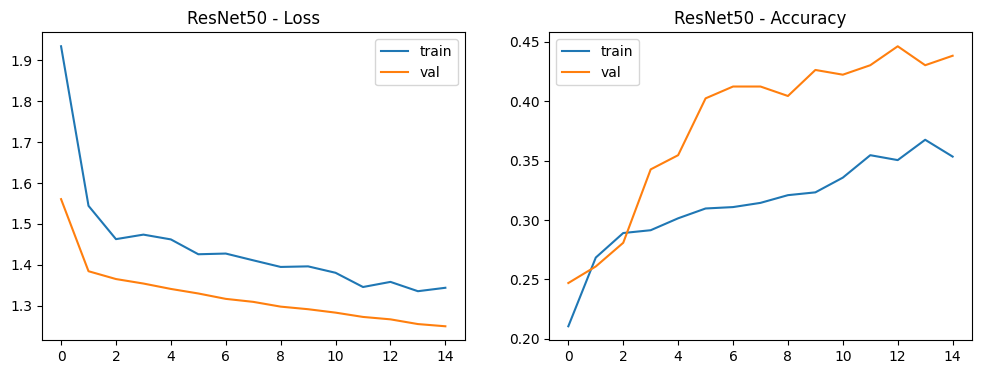


Training MobileNetV2 ...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2979 - loss: 1.7221

53/53 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.2987 - loss: 1.7196 - val_accuracy: 0.3167 - val_loss: 1.4406
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4043 - loss: 1.3297

53/53 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.4049 - loss: 1.3291 - val_accuracy: 0.4442 - val_loss: 1.2785
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4898 - loss: 1.1891

53/53 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.4903 - loss: 1.1885 - val_accuracy: 0.4980 - val_loss: 1.1606
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5641 - loss: 1.0744

53/53 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.5644 - loss: 1.0739 - val_accuracy: 0.5398 - val_loss: 1.0977
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6027 - loss: 0.9640

53/53 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.6029 - loss: 0.9638 - val_accuracy: 0.5737 - val_loss: 1.0221
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6232 - loss: 0.9001

53/53 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.6234 - loss: 0.8998 - val_accuracy: 0.5896 - val_loss: 0.9934
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6800 - loss: 0.8212

53/53 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.6798 - loss: 0.8215 - val_accuracy: 0.6135 - val_loss: 0.9298
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6569 - loss: 0.8103

53/53 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.6570 - loss: 0.8103 - val_accuracy: 0.6255 - val_loss: 0.9125
Epoch 9/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6792 - loss: 0.7848

53/53 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.6792 - loss: 0.7845 - val_accuracy: 0.6474 - val_loss: 0.8825
Epoch 10/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7074 - loss: 0.7455

53/53 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.7075 - loss: 0.7452 - val_accuracy: 0.6614 - val_loss: 0.8645
Epoch 11/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7162 - loss: 0.7279

53/53 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.7163 - loss: 0.7278 - val_accuracy: 0.6594 - val_loss: 0.8364
Epoch 12/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7239 - loss: 0.6634

53/53 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.7240 - loss: 0.6635 - val_accuracy: 0.6594 - val_loss: 0.8322
Epoch 13/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.7196 - loss: 0.6996 - val_accuracy: 0.6673 - val_loss: 0.8331
Epoch 14/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7434 - loss: 0.6680

53/53 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.7435 - loss: 0.6676 - val_accuracy: 0.6753 - val_loss: 0.8062
Epoch 15/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7419 - loss: 0.6581

53/53 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.7420 - loss: 0.6578 - val_accuracy: 0.6873 - val_loss: 0.7844


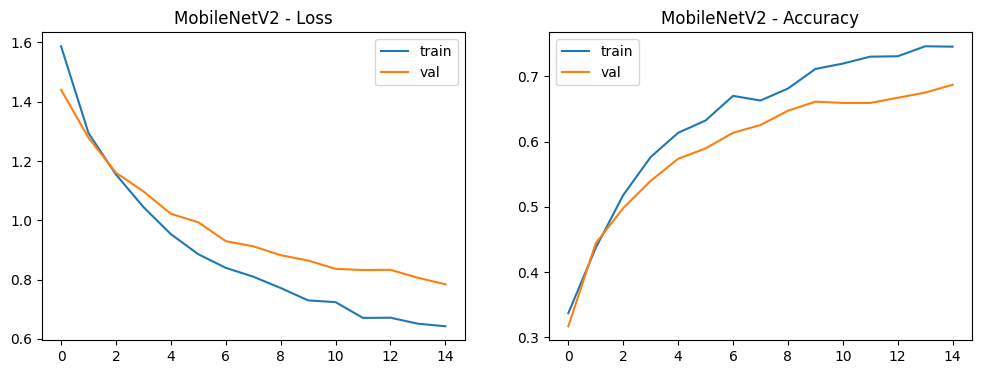


Training InceptionV3 ...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2935 - loss: 1.5499

53/53 ━━━━━━━━━━━━━━━━━━━━ 324s 6s/step - accuracy: 0.2943 - loss: 1.5483 - val_accuracy: 0.4223 - val_loss: 1.2839
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4317 - loss: 1.3066

53/53 ━━━━━━━━━━━━━━━━━━━━ 344s 6s/step - accuracy: 0.4320 - loss: 1.3060 - val_accuracy: 0.5339 - val_loss: 1.1310
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5358 - loss: 1.1243

53/53 ━━━━━━━━━━━━━━━━━━━━ 326s 6s/step - accuracy: 0.5358 - loss: 1.1240 - val_accuracy: 0.5837 - val_loss: 1.0202
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5628 - loss: 1.0343

53/53 ━━━━━━━━━━━━━━━━━━━━ 325s 6s/step - accuracy: 0.5631 - loss: 1.0339 - val_accuracy: 0.5996 - val_loss: 0.9614
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6273 - loss: 0.9456

53/53 ━━━━━━━━━━━━━━━━━━━━ 384s 6s/step - accuracy: 0.6273 - loss: 0.9457 - val_accuracy: 0.6494 - val_loss: 0.8941
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6401 - loss: 0.8990

53/53 ━━━━━━━━━━━━━━━━━━━━ 316s 6s/step - accuracy: 0.6400 - loss: 0.8989 - val_accuracy: 0.6753 - val_loss: 0.8496
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6483 - loss: 0.8909

53/53 ━━━━━━━━━━━━━━━━━━━━ 327s 6s/step - accuracy: 0.6483 - loss: 0.8907 - val_accuracy: 0.6773 - val_loss: 0.8410
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6927 - loss: 0.8231

53/53 ━━━━━━━━━━━━━━━━━━━━ 313s 6s/step - accuracy: 0.6926 - loss: 0.8231 - val_accuracy: 0.6932 - val_loss: 0.7975
Epoch 9/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6953 - loss: 0.7966

53/53 ━━━━━━━━━━━━━━━━━━━━ 314s 6s/step - accuracy: 0.6953 - loss: 0.7965 - val_accuracy: 0.7191 - val_loss: 0.7583
Epoch 10/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7236 - loss: 0.7417

53/53 ━━━━━━━━━━━━━━━━━━━━ 307s 6s/step - accuracy: 0.7235 - loss: 0.7418 - val_accuracy: 0.7131 - val_loss: 0.7519
Epoch 11/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7028 - loss: 0.7162

53/53 ━━━━━━━━━━━━━━━━━━━━ 324s 6s/step - accuracy: 0.7029 - loss: 0.7164 - val_accuracy: 0.7331 - val_loss: 0.7176
Epoch 12/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 305s 6s/step - accuracy: 0.7005 - loss: 0.7299 - val_accuracy: 0.7351 - val_loss: 0.7201
Epoch 13/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 304s 6s/step - accuracy: 0.7317 - loss: 0.7103 - val_accuracy: 0.7211 - val_loss: 0.7340
Epoch 14/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7449 - loss: 0.6401

53/53 ━━━━━━━━━━━━━━━━━━━━ 307s 6s/step - accuracy: 0.7447 - loss: 0.6407 - val_accuracy: 0.7351 - val_loss: 0.6878
Epoch 15/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 304s 6s/step - accuracy: 0.7357 - loss: 0.6667 - val_accuracy: 0.7450 - val_loss: 0.6887


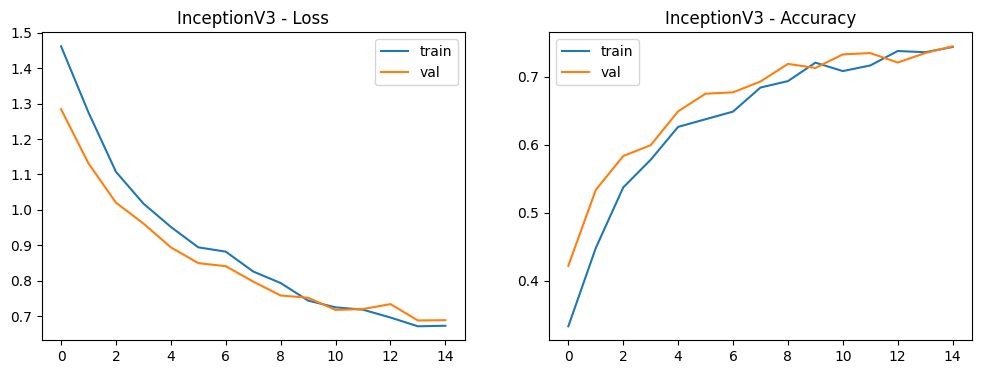

In [8]:
# 5️) MODEL TRAINING

print("✅ Training models...")
results = []

def train_model(model, name):
    print(f"\nTraining {name} ...")
    cb = [
        callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        callbacks.ModelCheckpoint(f"{OUTPUT_DIR}/{name}_best.h5", save_best_only=True)
    ]
    model.compile(optimizer=optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cb)
    # Plot history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'{name} - Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'{name} - Accuracy'); plt.legend()
    plt.show()
    return model, history

# Train Custom CNN
custom_cnn, history_cnn = train_model(custom_cnn, "CustomCNN")

# Train Transfer Models
for name, model in transfer_models.items():
    model, hist = train_model(model, name)
    transfer_models[name] = model

✅ Evaluating models...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


📊 CustomCNN Results:
Accuracy=0.3252  Precision=0.1066  Recall=0.3252  F1=0.1606
              precision    recall  f1-score   support

      glioma       0.33      1.00      0.49        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.33       246
   macro avg       0.08      0.25      0.12       246
weighted avg       0.11      0.33      0.16       246



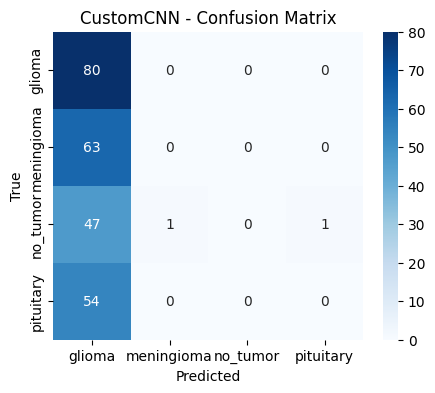

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


📊 ResNet50 Results:
Accuracy=0.4390  Precision=0.3172  Recall=0.4390  F1=0.3179
              precision    recall  f1-score   support

      glioma       0.39      1.00      0.56        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.77      0.55      0.64        49
   pituitary       0.17      0.02      0.03        54

    accuracy                           0.44       246
   macro avg       0.33      0.39      0.31       246
weighted avg       0.32      0.44      0.32       246



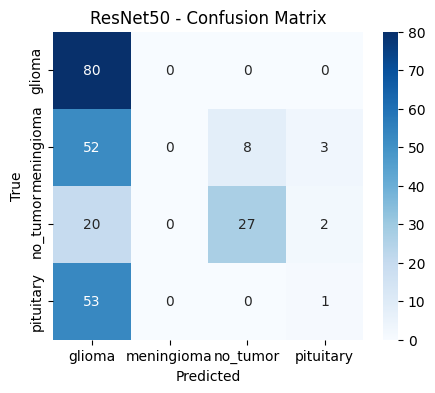


📊 MobileNetV2 Results:
Accuracy=0.6829  Precision=0.7421  Recall=0.6829  F1=0.6779
              precision    recall  f1-score   support

      glioma       0.84      0.70      0.76        80
  meningioma       0.73      0.38      0.50        63
    no_tumor       0.88      0.71      0.79        49
   pituitary       0.50      0.98      0.66        54

    accuracy                           0.68       246
   macro avg       0.73      0.69      0.68       246
weighted avg       0.74      0.68      0.68       246



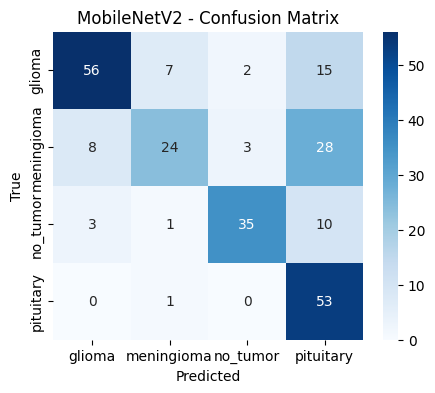


📊 InceptionV3 Results:
Accuracy=0.7033  Precision=0.7338  Recall=0.7033  F1=0.6908
              precision    recall  f1-score   support

      glioma       0.78      0.78      0.78        80
  meningioma       0.77      0.38      0.51        63
    no_tumor       0.78      0.73      0.76        49
   pituitary       0.57      0.94      0.71        54

    accuracy                           0.70       246
   macro avg       0.73      0.71      0.69       246
weighted avg       0.73      0.70      0.69       246



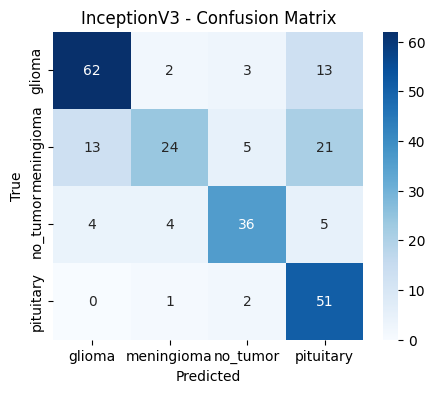

In [9]:
# 6️) MODEL EVALUATION

print("✅ Evaluating models...")

def evaluate_model(model, name):
    y_true, y_pred = [], []
    for imgs, labels in test_ds:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"\n📊 {name} Results:")
    print(f"Accuracy={acc:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()
    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# Evaluate all models
results.append(evaluate_model(custom_cnn, "CustomCNN"))
for name, model in transfer_models.items():
    results.append(evaluate_model(model, name))


✅ Model Comparison Summary:
         model  accuracy  precision    recall        f1
3  InceptionV3  0.703252   0.733768  0.703252  0.690841
2  MobileNetV2  0.682927   0.742109  0.682927  0.677913
1     ResNet50  0.439024   0.317152  0.439024  0.317936
0    CustomCNN  0.325203   0.106624  0.325203  0.160594


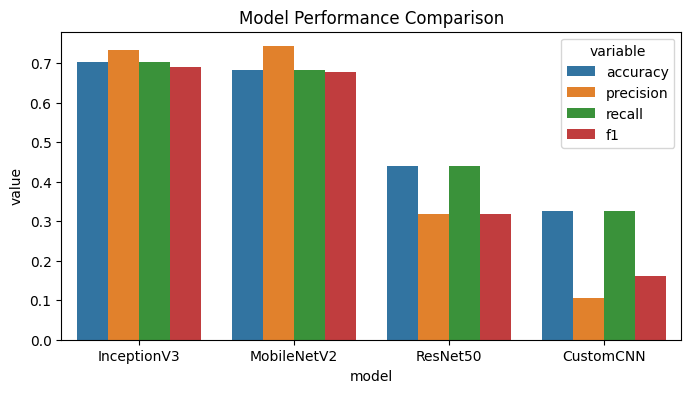


🏆 Best Performing Model: InceptionV3


In [10]:
# 7️) MODEL COMPARISON

df = pd.DataFrame(results).sort_values("f1", ascending=False)
print("\n✅ Model Comparison Summary:")
print(df)

plt.figure(figsize=(8,4))
sns.barplot(data=df.melt(id_vars='model', value_vars=['accuracy','precision','recall','f1']),
            x='model', y='value', hue='variable')
plt.title("Model Performance Comparison")
plt.show()

best_model_name = df.iloc[0]["model"]
print(f"\n🏆 Best Performing Model: {best_model_name}")

In [11]:
import pickle
from tensorflow.keras.models import load_model

# save to h5
best_model_path = f"models_outputs/{best_model_name}_best.h5"
best_model = load_model(best_model_path)

# Save to pickle
pickle_path = f"models_outputs/{best_model_name}_best.pkl"
with open(pickle_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"✅ Saved best model as: {pickle_path}")

✅ Saved best model as: models_outputs/InceptionV3_best.pkl
